## Image Classification - Spring Position

The Step Valve (SV) is used to control the flame intensity in gas cook-tops. The SV is made of 28 components and in this document we are analyzing mainly two of them, the Bush Valve (BV) and the spring that goes inserted in the BV. Each SV contains 9 bush SVs and consequentely 9 springs. Sometimes this spring is slightly inlined toward outside and it can cause gas leaking.  This doc presents the implementation of a Convolutional Neural Network that can be able of detecting if the a spring in inclined or not. In the image below we can see 3 BV with the springs inserted. Two of them are in the right position and one one them in inclined (middle one). 


<img src="files/BOTH_29.png">

### Dataset

To train our CNN we have first "cleaned" our images, i.e., we remove all the noise of the image above and leave only what we want to classify. To that task I have used Excel (VBA). Finally we have the images below. In the left one the spring is okay and in the right one it is moved.

<img src="files/Spring_Detailed.png">

We have a classification proble where we want to identify if a given spring is moved or not. The two classes defined are OK (spring in the right position) and NOK (spring inclined). To be able to train our model there is a specific structure that the images must be inside the folders. The figure below shows that structure.

<img src="files/Data_Str.png">

We are using 430 images for train, 121 for validation and 178 for test.

In [1]:
#Importing the necessary packages.
import keras
keras.__version__
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras.backend import clear_session
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
import os
import shutil
from random import sample, randint
import seaborn as sns

Using TensorFlow backend.


### Building the CNN

The input shape is (150, 150, 1) because we are starting with images of size 150 x 150, that was chosen randomly and the number "1" is related to the fact the images are black and white. 

In [23]:
clear_session()

model = models.Sequential()
model.add(layers.Conv2D(32,kernel_size=3 , activation="relu", input_shape=(150,150,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64,kernel_size=3 , activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128,kernel_size=3 , activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128,kernel_size=3 , activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Defining the optimizer and its learning rate and the metrics for model evaluation.

In [25]:
from keras import optimizers


RMS=keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer = RMS,loss = "binary_crossentropy" , metrics=['accuracy'])

### Data preprocessing
The images must be properly formatted in floating tensors before they are given to the network. This is just what we are going to do here. We are rescaling the pixel values (between 0 and 255) to the interval [0, 1] since neural networks prefer to work with small values. We are using also a data augmentatiom method that flips our images in the train dataset.

In [27]:
from keras.preprocessing.image import ImageDataGenerator

#Usind Data Augmentation due the characteristics of my dataset
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory("Images/Train", color_mode = "grayscale", target_size=(150,150), class_mode = "binary", batch_size=20)
validation_generator = validation_datagen.flow_from_directory("Images/Validation", color_mode = "grayscale", target_size=(150,150), class_mode = "binary", batch_size=20)
test_generator = test_datagen.flow_from_directory("Images/Test", color_mode = "grayscale", target_size=(150,150), class_mode = "binary", batch_size=20)

Found 430 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Found 178 images belonging to 2 classes.


Let's take a look at one of these generators: it takes us to a batch of 150x150 BW images (dimensions `(20, 150, 150, 1)`) and binary labels (dimension `(20,)`). 20 is the number of examples in each batch (what we call the batch size). The generator generates these batches indefinitely: run a loop through all the images we have in the folder. That's why we have to write break to break the loop at some point.

In [28]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 1)
labels batch shape: (20,)


Let's run the fit using "model.fit_generator". We are running 30 epochs here.

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import time

In [10]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
time_callback = TimeHistory()
early_stopping_callback = EarlyStopping(monitor = "val_acc", patience = 10)
checkpoint = ModelCheckpoint("model_02.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto")
history_1 = model.fit_generator(train_generator,
                             epochs=30,
                             steps_per_epoch=30,
                             validation_data = validation_generator,
                             validation_steps = 10,
                             callbacks = [checkpoint, time_callback, early_stopping_callback])

Epoch 1/30
30/30 [==============================] - 25s 820ms/step - loss: 0.6707 - acc: 0.5501 - val_loss: 0.6776 - val_acc: 0.5304

Epoch 00001: val_acc improved from -inf to 0.53039, saving model to model_02.h5
Epoch 2/30
30/30 [==============================] - 25s 820ms/step - loss: 0.6404 - acc: 0.6216 - val_loss: 0.6645 - val_acc: 0.6298

Epoch 00002: val_acc improved from 0.53039 to 0.62983, saving model to model_02.h5
Epoch 3/30
30/30 [==============================] - 22s 729ms/step - loss: 0.5815 - acc: 0.6850 - val_loss: 0.5713 - val_acc: 0.6975

Epoch 00003: val_acc improved from 0.62983 to 0.69753, saving model to model_02.h5
Epoch 4/30
30/30 [==============================] - 21s 692ms/step - loss: 0.4879 - acc: 0.7831 - val_loss: 0.6196 - val_acc: 0.6519

Epoch 00004: val_acc did not improve from 0.69753
Epoch 5/30
30/30 [==============================] - 21s 688ms/step - loss: 0.4084 - acc: 0.8250 - val_loss: 0.3923 - val_acc: 0.7963

Epoch 00005: val_acc improved from

Let's check how long it takes to run 30 epochs

In [12]:
time_1 = np.cumsum(time_callback.times)

In [13]:
time_1[-1]

array([ 24.93331122,  49.83448529,  72.06662345,  92.84350443,
       113.89158893, 134.97485495, 159.64715385, 180.77026486,
       201.86848092, 222.15521622, 242.81463814, 267.46331382,
       288.8184073 , 308.96988034, 329.9382062 , 354.16491199,
       376.51190352, 398.10411263, 418.89765286, 439.35884929,
       464.00017858, 485.60070562, 506.66810703, 526.87597585,
       548.1596787 , 572.44795966, 594.0201683 , 614.99050117,
       636.11812901, 656.70410752])

It took around 650 seconds to run the model and the results are quite satisfying.

Let's plot the accuracy to see how it evolves over time.

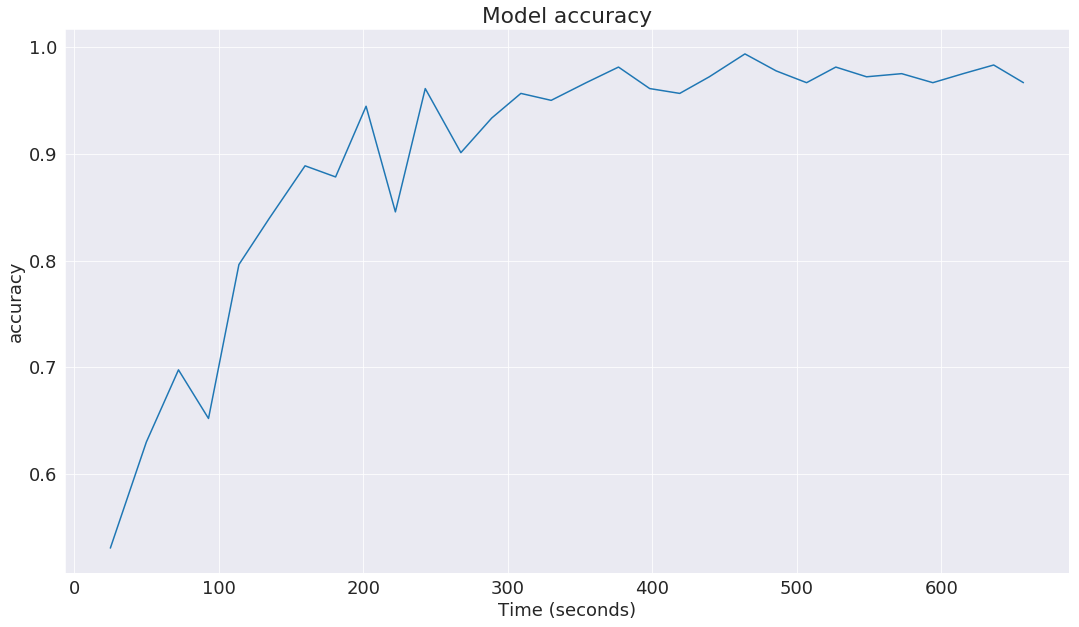

In [21]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 18})
plt.plot(time_1, history_1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Time (seconds)')
plt.show()

After 30 epochs the accuracy obtained was around 99.83%. Now it is time to test our model in the Test dataset

In [17]:
model = load_model('model_02.h5')

In [18]:
test_loss_1, test_acc_1 = model.evaluate_generator(test_generator)

In [19]:
print(test_loss_1,test_acc_1)

0.1437248873492975 0.9550561677204089


The results are quite good. The accuracy for the Test dataset is around 95.5%.